In [1]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import hopsworks
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
wine_df = pd.read_csv("Dataset/winequalityN.csv")
wine_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [57]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [58]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [59]:
wine_df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

### Exploratory Data Analysis (EDA)  our Wine Data
We see that the data is skewed and has a lot more instances of wines with quality of around 5-7 and a lot fewer examples for 9, 3, 8 and 4. Furthermore, there are no instances of wine with quality of 0, 1, 2 and 10. This will pose an issue if we would try to train a classifier, since we have no examples of the lowest and highest quality of wine. This means that the classifier would never attribute 0, 1, 2 and 10 to any wine in order to minimize loss.

We will as such split each quality into a group and train a model to classify this:

Low quality (0-5), Good quality (6), High quality (7-10

The types will be changed into a number, 0 for white and 1 for red.


In [60]:
wine_df['quality'] = wine_df.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 6 else 2)
wine_df['type'] = wine_df.type.apply(lambda q: 0 if q == 'white' else 1)
wine_df['quality'].value_counts()

quality
1    2836
0    2384
2    1277
Name: count, dtype: int64

In [61]:
wine_df = wine_df.dropna()
wine_df['quality'].value_counts()

quality
1    2820
0    2372
2    1271
Name: count, dtype: int64

We opt to simply drop the columns with empty values, since there's so few in the dataset it is likely to have a non-appreciable effect on the outputs.

Now we have a good distribution of counts for each quality category where 0 is low quality, 1 is good quality and 2 is high quality. Now we need to do some feature engineering to figure out which features have predictive power.

In [62]:
low_quality = round(wine_df[wine_df['quality'] == 0][wine_df.columns].describe(),2)
good_quality = round(wine_df[wine_df['quality'] == 1][wine_df.columns].describe(),2)
high_quality = round(wine_df[wine_df['quality'] == 2][wine_df.columns].describe(),2)
pd.concat([low_quality, good_quality, high_quality], keys=['Low Quality Wine', 'Good Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
type                           2372.0    0.31   0.46  0.00   0.00    0.00   
fixed acidity                  2372.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2372.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2372.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2372.0    5.63   4.91  0.60   1.80    2.90   
chlorides                      2372.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2372.0   29.48  19.86  2.00  14.00   26.00   
total sulfur dioxide           2372.0  119.21  61.90  6.00  68.00  124.00   
density                        2372.0    1.00   0.00  0.99   0.99    1.00   
pH                             2372.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2372.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2372.0    9.87   0.84  8.00   9.30    9.60   
quality                        2372.0    0.00   0.00  0.00   0.00    0.00   

                                     Good Quality Wine          ...          \
                         75%     max             count    mean  ...     75%   
type                    1.00    1.00            2820.0    0.22  ...    0.00   
fixed acidity           7.80   15.90            2820.0    7.18  ...    7.60   
volatile acidity        0.50    1.58            2820.0    0.31  ...    0.37   
citric acid             0.40    1.00            2820.0    0.32  ...    0.39   
residual sugar          8.50   23.50            2820.0    5.56  ...    8.30   
chlorides               0.08    0.61            2820.0    0.05  ...    0.06   
free sulfur dioxide    42.00  289.00            2820.0   31.15  ...   42.00   
total sulfur dioxide  167.00  440.00            2820.0  115.39  ...  156.00   
density                 1.00    1.00            2820.0    0.99  ...    1.00   
pH                      3.31    3.90            2820.0    3.22  ...    3.32   
sulphates               0.58    2.00            2820.0    0.53  ...    0.60   
alcohol                10.40   14.90            2820.0   10.59  ...   11.40   
quality                 0.00    0.00            2820.0    1.00  ...    1.00   

                             High Quality Wine                              \
                         max             count    mean    std   min    25%   
type                    1.00            1271.0    0.17   0.38  0.00   0.00   
fixed acidity          14.30            1271.0    7.09   1.35  3.90   6.30   
volatile acidity        1.04            1271.0    0.29   0.12  0.08   0.20   
citric acid             1.66            1271.0    0.33   0.11  0.00   0.28   
residual sugar         65.80            1271.0    4.84   4.07  0.80   1.80   
chlorides               0.42            1271.0    0.04   0.02  0.01   0.03   
free sulfur dioxide   112.00            1271.0   31.05  15.32  3.00  20.00   
total sulfur dioxide  294.00            1271.0  109.82  47.09  7.00  87.00   
density                 1.04            1271.0    0.99   0.00  0.99   0.99   
pH                      4.01            1271.0    3.23   0.16  2.84   3.12   
sulphates               1.95            1271.0    0.54   0.16  0.22   0.42   
alcohol                14.00            1271.0   11.44   1.22  8.50  10.70   
quality                 1.00            1271.0    2.00   0.00  2.00   2.00   

                                              
                         50%     75%     max  
type                    0.00    0.00    1.00  
fixed acidity           6.90    7.40   15.60  
volatile acidity        0.27    0.34    0.92  
citric acid             0.32    0.38    0.76  
residual sugar          2.90    6.52   19.25  
chlorides               0.04    0.05    0.36  
free sulfur dioxide    31.00   40.00  108.00  
total sulfur dioxide  114.00  140.00  289.00  
density                 0.99    1.00  

Here we see that alcohol seems to be a especially predictive variable as it increases drastically between low, good and high quality wine while it has a moderately low standard deviation. Other good features seem to be type (white whine seems to be of higher quality in general), residual sugar, volatile/fixed acidity, density, citric acid and total/free sulfur dioxide. The rest (Sulphates and pH), seems to hold little to no predictive power since their mean does not change between categories and the standard deviation is high in relation to the shift in mean! As such we will drop these columns and continue to monitor the rest.

Next we will check if there's any drastic covariance.

<Axes: >

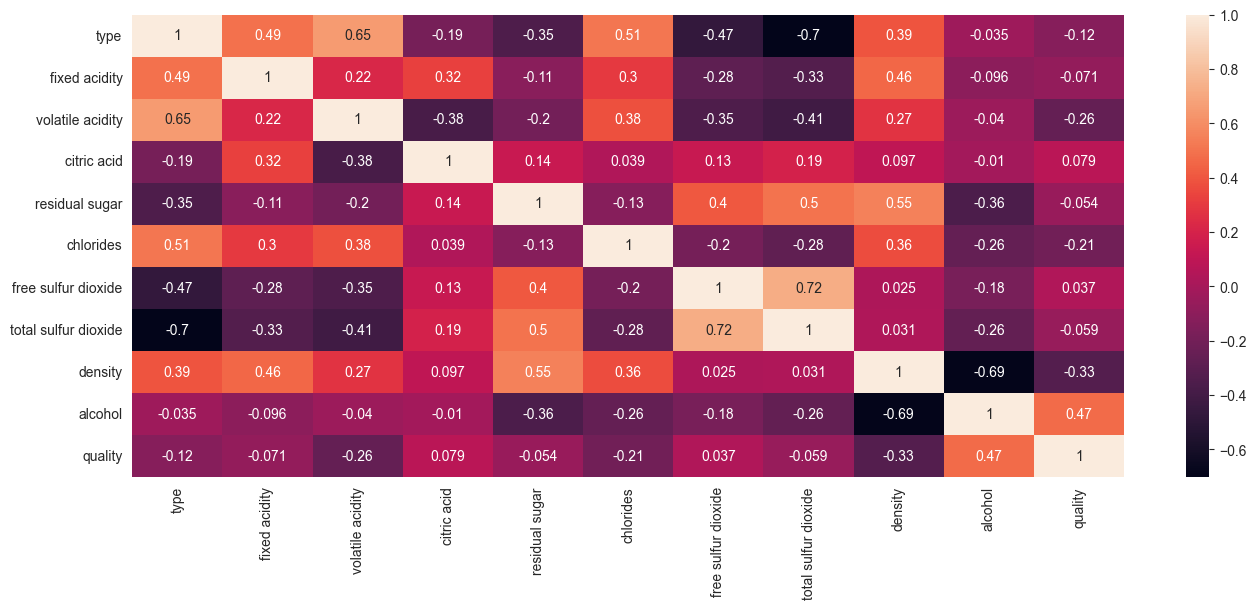

In [63]:
wine_df = wine_df.drop(columns=['sulphates', 'pH'])
plt.figure(figsize=(16, 6))
sns.heatmap(wine_df.corr(), annot=True)

We see that free sulfur dioxide and total sulfur dioxide correlate a lot so we will remove free sulfur dioxide since it correlates less with quality. We see that volatile acidity and fixed acidity correlates as well, and fixed acidity has low correlation with quality, so we choose to drop this variable as well.

In [64]:
wine_df = wine_df.drop(columns=['free sulfur dioxide', 'fixed acidity'])

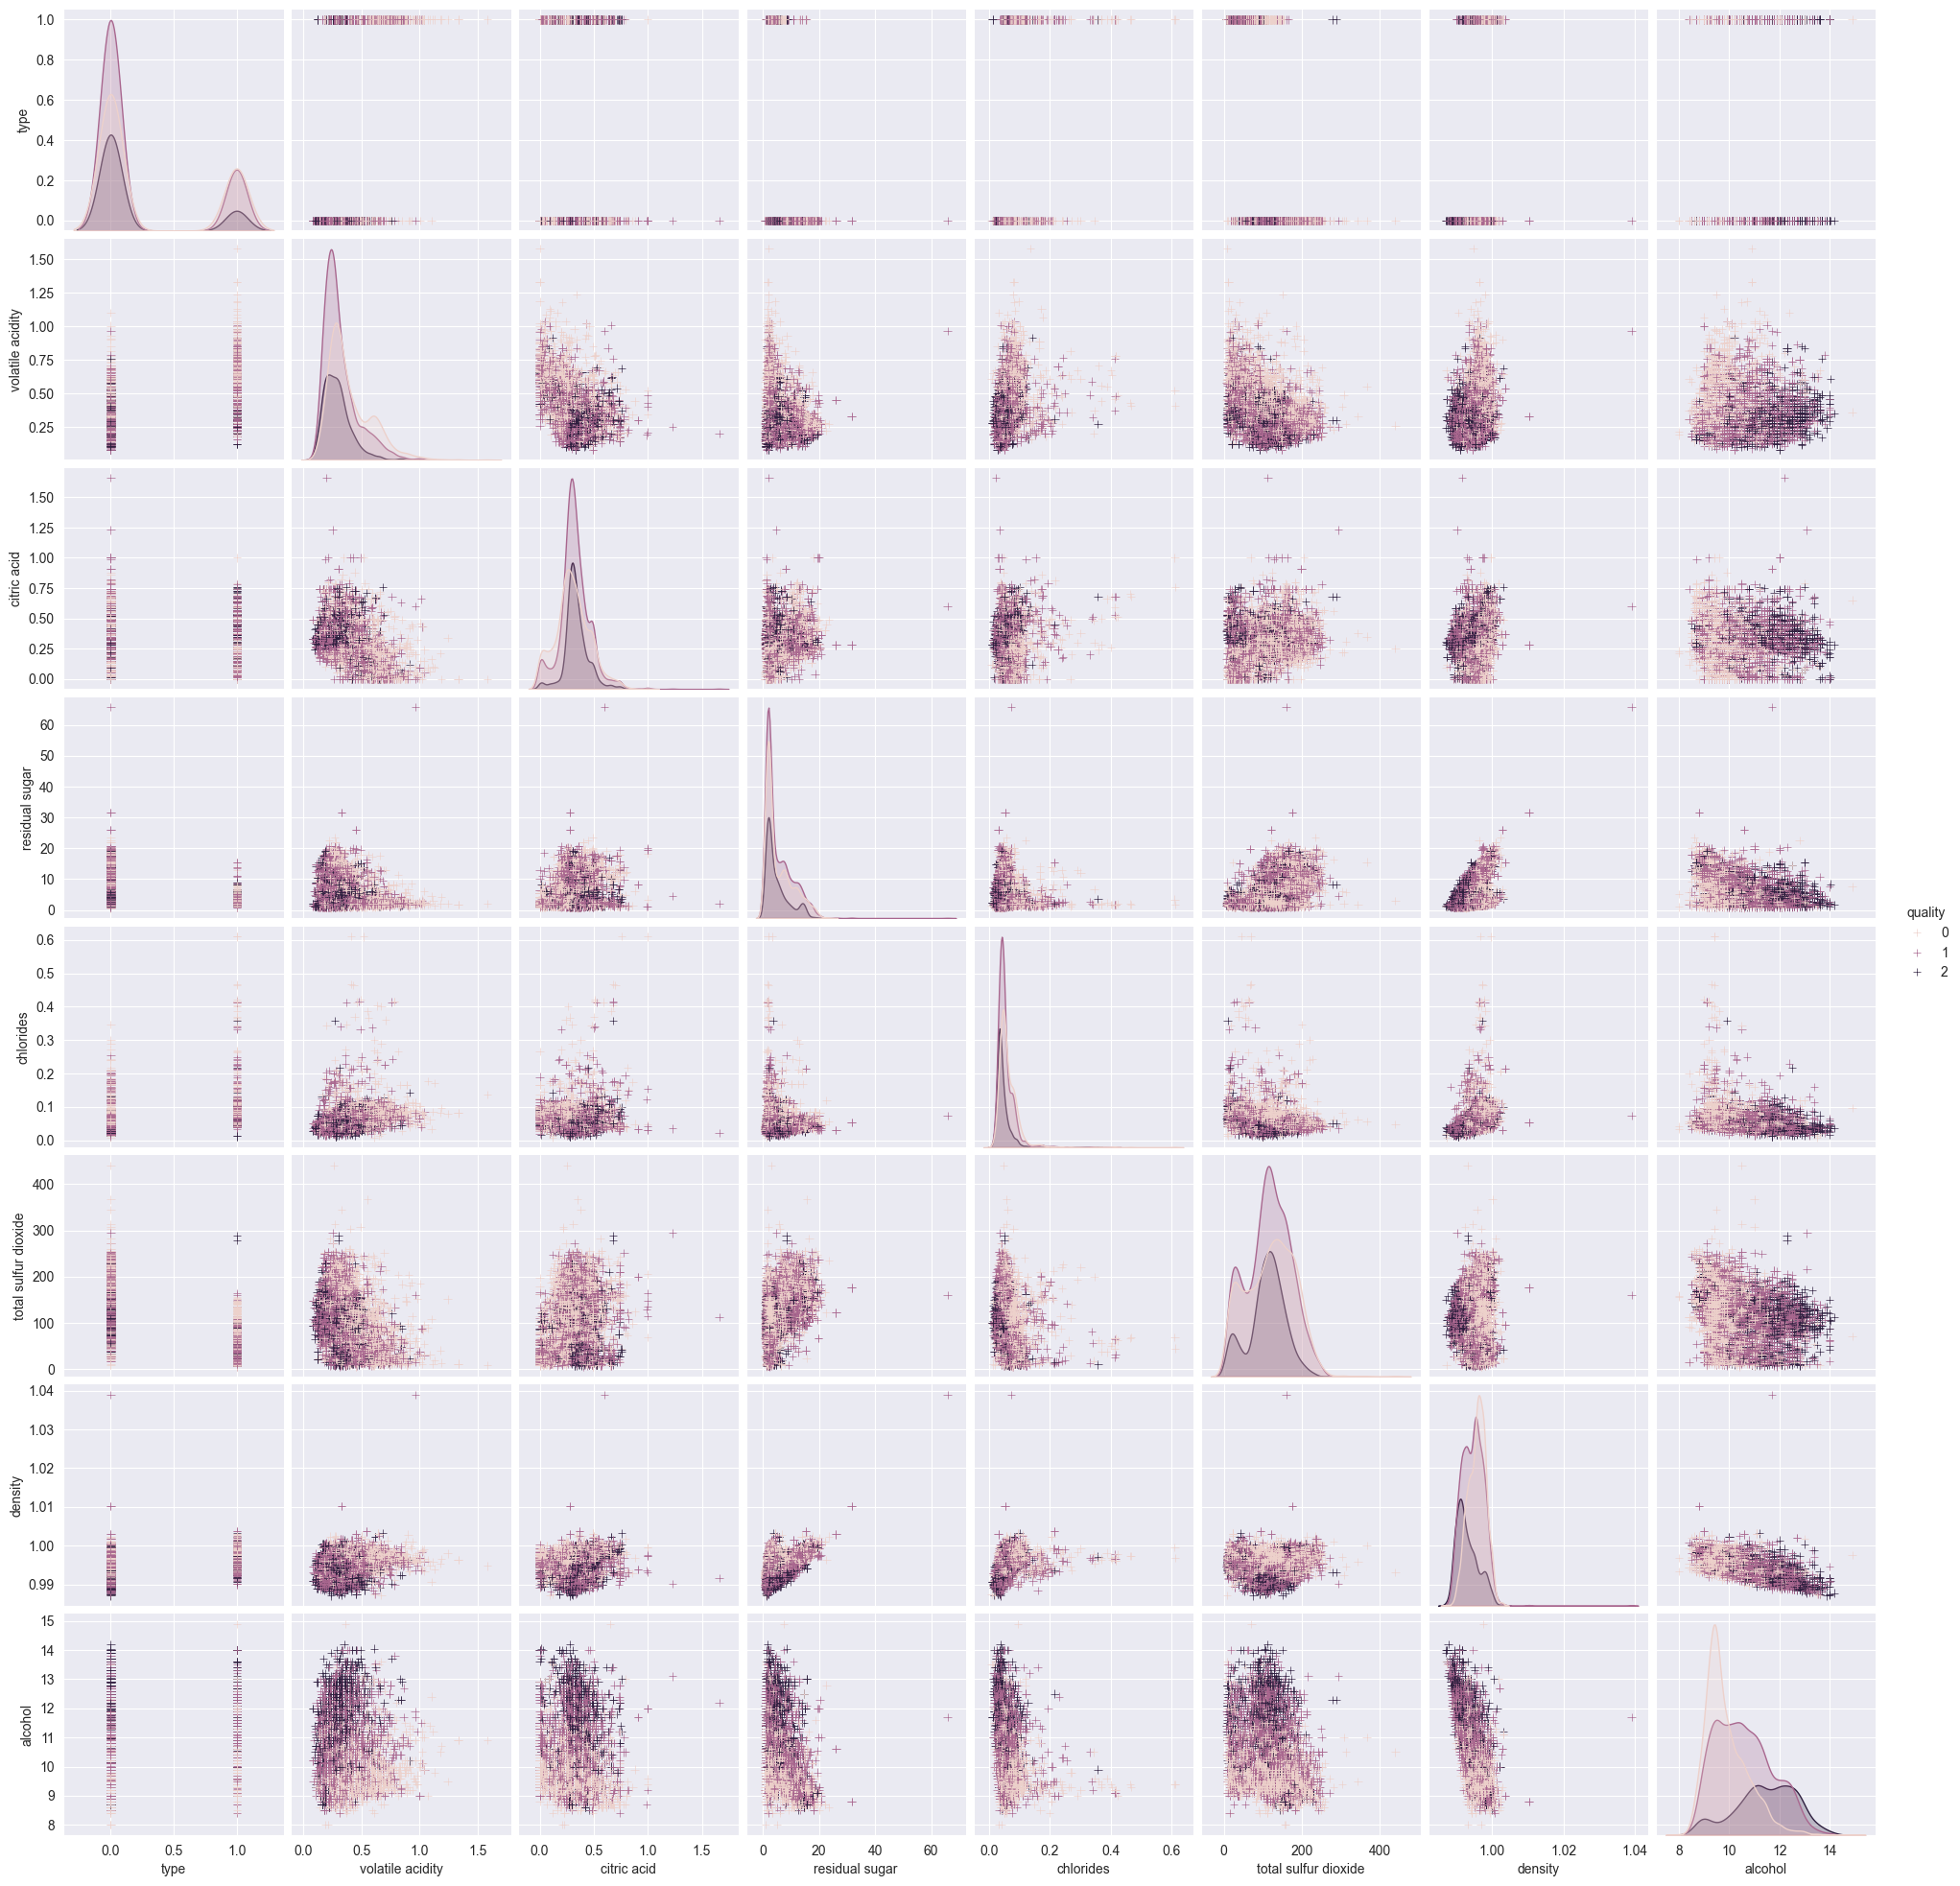

In [65]:
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

Looking at the graphs we see that residual sugar does not hold much predictive power, since the distribution across qualities are very similar. We choose to drop this variable as well

In [66]:
wine_df = wine_df.drop(columns=['residual sugar'])

### Visualize range of values 

We want to design a simulator to generate the 3 types of quality wine.
To do this, we can visualize the range of values for the features we have chosen for each quality.

In [67]:
class_data = wine_df.copy()
class_data['quality'] = class_data.quality.apply(lambda q: 'Low quality' if q == 0 else 'Good quality' if q == 1 else 'High quality')

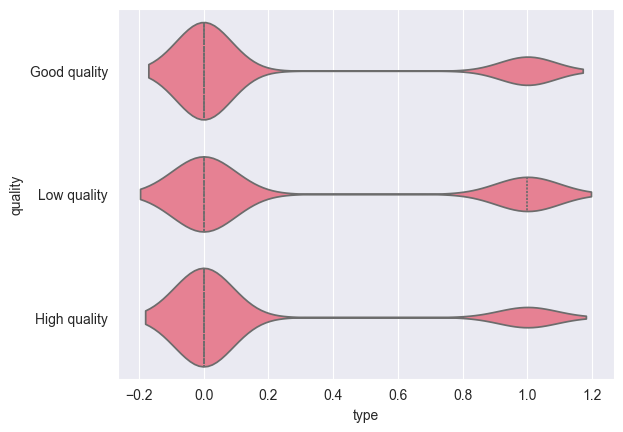

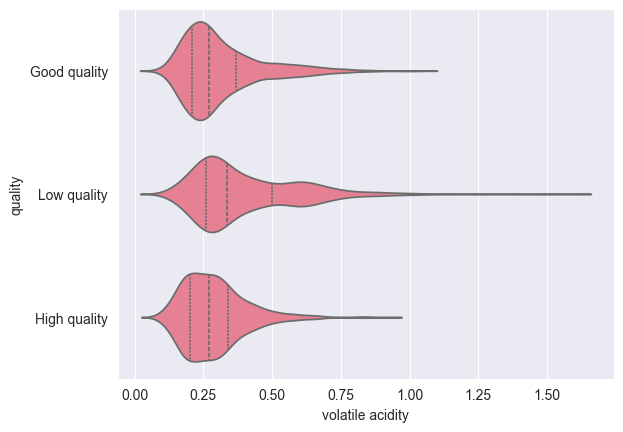

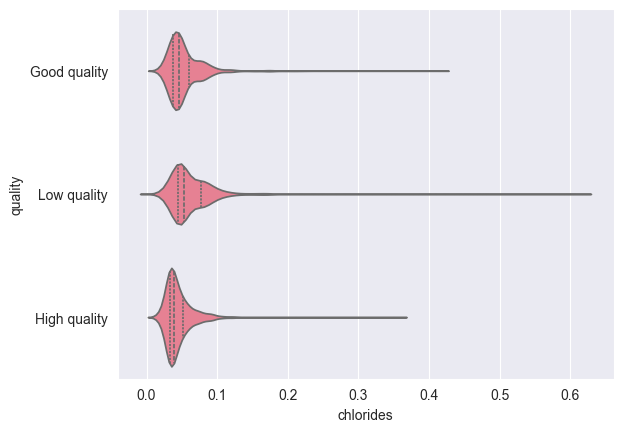

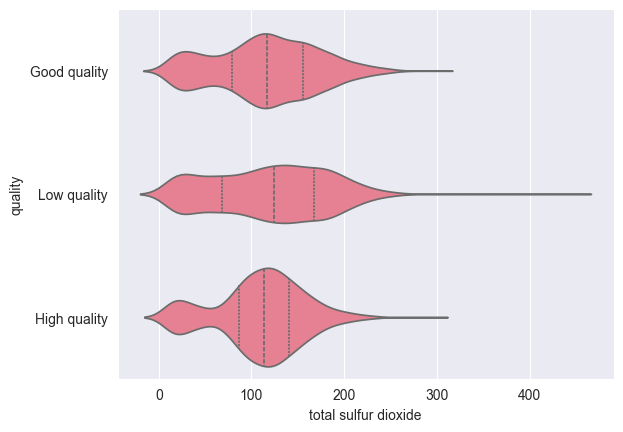

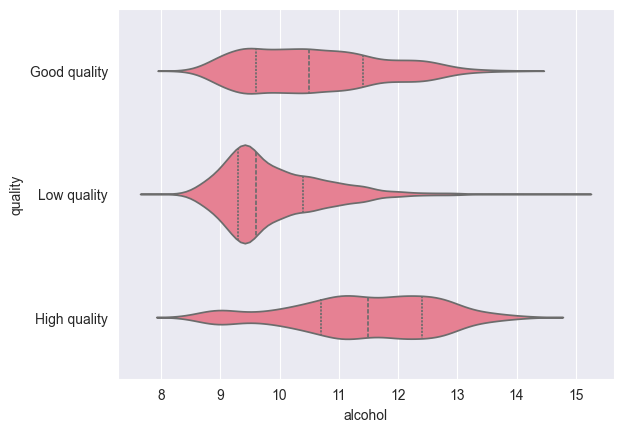

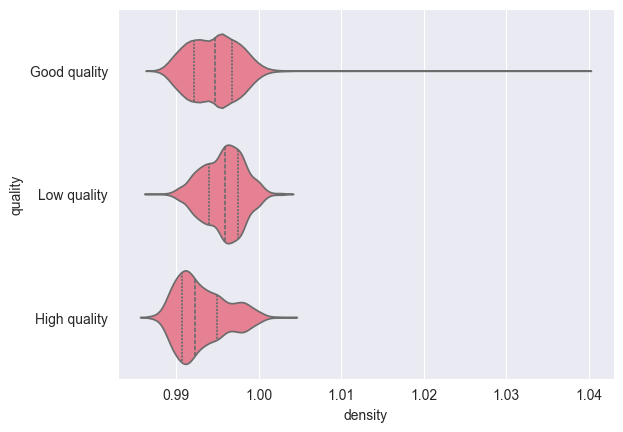

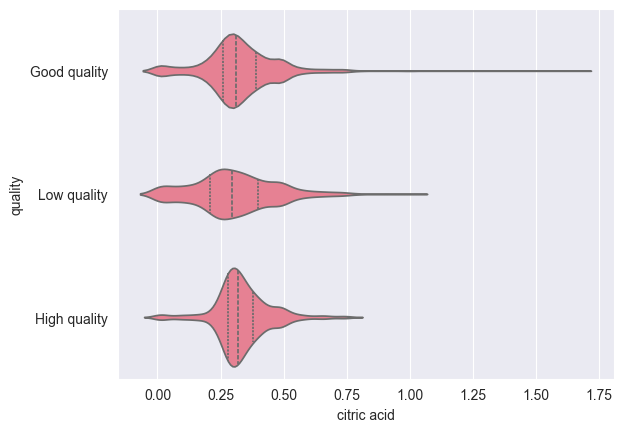

In [68]:
g = sns.violinplot(y='quality', x='type', data=class_data, inner='quartile')
plt.show()
g = sns.violinplot(y='quality', x='volatile acidity', data=class_data, inner='quartile')
plt.show()
g = sns.violinplot(y='quality', x='chlorides', data=class_data, inner='quartile')
plt.show()
g = sns.violinplot(y='quality', x='total sulfur dioxide', data=class_data, inner='quartile')
plt.show()
g = sns.violinplot(y='quality', x='alcohol', data=class_data, inner='quartile')
plt.show()
g = sns.violinplot(y='quality', x='density', data=class_data, inner='quartile')
plt.show()
g = sns.violinplot(y='quality', x='citric acid', data=class_data, inner='quartile')
plt.show()

### Insert our Wine DataFrame into a FeatureGroup
Let's write our historical wine feature values and labels to a feature group.
When you write historical data, this process is called `backfilling`.

In [70]:
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=["type", "volatile_acidity", "citric_acid", "chlorides", 'total_sulfur_dioxide', 'alcohol', 'density'],
    description="Wine quality dataset")
wine_df = wine_df.rename(columns={'volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'total sulfur dioxide': 'total_sulfur_dioxide'})
wine_fg.insert(wine_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/191638/fs/191557/fg/224661


Uploading Dataframe: 0.00% |          | Rows 0/6463 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/191638/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1b88d3c29d0>, None)

### Data Validation
If you want, you can enable data validation for your feature group.
The code below will prevent iris flower data from being written your your feature group if you write values outside the expected ranges.

In [71]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column, 
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [72]:
suite = ExpectationSuite(expectation_suite_name="iris_dimensions")
expect(suite, "type", 0, 1)
expect(suite, "volatile_acidity", 0.01, 2.0)
expect(suite, "citric_acid", 0.0, 1.7)
expect(suite, "chlorides", 0.001, 1.0)
expect(suite, 'total_sulfur_dioxide', 1.0, 350)
expect(suite, 'density', 0.95, 1.05)
expect(suite, 'alcohol', 5, 20)
wine_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")

Attached expectation suite to Feature Group, edit it at https://c.app.hopsworks.ai:443/p/191638/fs/191557/fg/224661


In [73]:
wine_df.describe()

,type,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol,quality
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,0.246480,0.339589,0.318758,0.056056,115.694492,0.994698,10.492825,0.829646
std,0.430995,0.164639,0.145252,0.035076,56.526736,0.003001,1.193128,0.731254
min,0.000000,0.080000,0.000000,0.009000,6.000000,0.987110,8.000000,0.000000
25%,0.000000,0.230000,0.250000,0.038000,77.000000,0.992330,9.500000,0.000000
50%,0.000000,0.290000,0.310000,0.047000,118.000000,0.994890,10.300000,1.000000
75%,0.000000,0.400000,0.390000,0.065000,156.000000,0.997000,11.300000,1.000000
max,1.000000,1.580000,1.660000,0.611000,440.000000,1.038980,14.900000,2.000000
